**Import neccesary libraries**

In [ ]:
#for fetching the fetching and storing data

import os

from zipfile import ZipFile

import json



#for image processing

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import cv2

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator



#for model creation

!pip install keras-tuner

import keras_tuner as kt

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization

from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3,DenseNet201




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

**Set the enviornment vaiables & load dataset**

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:36<00:00, 22.3MB/s]
100% 2.04G/2.04G [01:36<00:00, 22.7MB/s]


In [ ]:
##unzip the file

with ZipFile("/content/plantvillage-dataset.zip","r") as zf:

  zf.extractall()

In [ ]:
##checking dataset



print(len(os.listdir("/content/plantvillage dataset/color")))

print(os.listdir("/content/plantvillage dataset/color")[:3])



print(len(os.listdir("/content/plantvillage dataset/color/Apple___Apple_scab")))

print(os.listdir("/content/plantvillage dataset/color/Apple___Apple_scab")[:3])

38
['Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___healthy']
630
['0ea78733-9404-4536-8793-a108c66269b3___FREC_Scab 3145.JPG', 'b006c4b8-5f33-4794-91bd-7aaa430e6ceb___FREC_Scab 3498.JPG', '40a5e87c-ee32-4d67-9b28-926e94638a1d___FREC_Scab 3251.JPG']


(256, 256, 3)


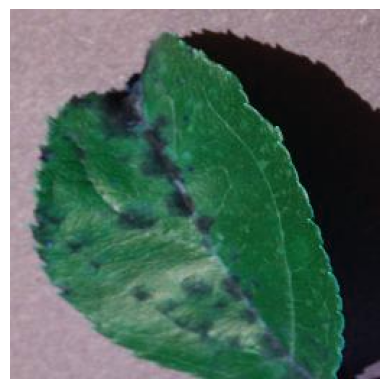

In [ ]:
##Image of sample

img_path="/content/plantvillage dataset/color/Apple___Apple_scab/0261a6e4-21f8-481a-8827-b674e6955644___FREC_Scab 3055.JPG"



img=cv2.imread(img_path)

plt.imshow(img)

plt.axis("off")

print(img.shape)

**Dataset Processsing**

In [ ]:
##data directory

base_dir="/content/plantvillage dataset/color"



##creating datagenerator

data_gen=ImageDataGenerator(

    rescale=1/255,

    validation_split=0.2

)

In [ ]:
##training data

train=data_gen.flow_from_directory(

    base_dir,

    batch_size=32,

    target_size=(224,224),

    subset="training",

    class_mode="categorical"

)



##validation data

validation=data_gen.flow_from_directory(

    base_dir,

    batch_size=32,

    target_size=(224,224),

    subset="validation",

    class_mode="categorical"

)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [ ]:
print(f"Shape of image numpy array ={train[0][0].shape[1:]}")

print(f"Shape of image class numpy array ={train[0][1].shape[1:]}")

Shape of image numpy array =(224, 224, 3)
Shape of image class numpy array =(38,)


**Model Creation**

Non-pretrained Model

In [ ]:
def build_model(hp):

  model=Sequential()



  for layers in range(hp.Choice("layers",values=[3])):

    if layers==0:

      model.add(Conv2D(hp.Choice("nodes",values=[32]),

                       kernel_size=(8,8),

                       padding="same",

                       activation="relu",

                       input_shape=(224,224,3)))

    else:

      model.add(Conv2D(hp.Choice("nodes",values=[32]),

                       kernel_size=(8,8),

                       padding="same",

                       activation="relu"))



    model.add(BatchNormalization())



    if layers<3:

      model.add(MaxPooling2D(pool_size=(2,2),strides=2))



  model.add(Flatten())

  model.add(Dense(38,activation="softmax"))



  model.compile(

      optimizer=hp.Choice("optimizers",values=["Adam"]),

      loss="categorical_crossentropy",

      metrics=["accuracy"]

  )



  return model



tuner=kt.RandomSearch(

    build_model,

    objective="val_accuracy",

    max_trials=1,

    directory="fine_tune",

    project_name="fine_tune"

)



tuner.search(train,validation_data=validation,epochs=10)



best_model=tuner.get_best_models(num_models=1)[0]

best_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |layers
32                |32                |nodes
Adam              |Adam              |optimizers

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

Pretrained Models

In [ ]:
##VGG16

base_model=VGG16(

    include_top=False,

    weights="imagenet",

    input_shape=(224,224,3)

)



model_vgg=Sequential()



model_vgg.add(base_model)

model_vgg.add(Flatten())

model_vgg.add(Dense(38,activation="softmax"))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
##training model on dataset

models=[model_vgg]

for model in models:

  print(f"{model}")

  print()

  model.compile(

      optimizer="Adam",

      loss="categorical_crossentropy",

      metrics=["accuracy"]

  )

  model.fit(train,validation_data=validation,epochs=10)

<Sequential name=sequential_1, built=False>

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 616s 419ms/step - accuracy: 0.3841 - loss: 2.5031 - val_accuracy: 0.7363 - val_loss: 0.8423
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 416ms/step - accuracy: 0.7815 - loss: 0.7049 - val_accuracy: 0.8328 - val_loss: 0.5271
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 564s 415ms/step - accuracy: 0.8476 - loss: 0.4704 - val_accuracy: 0.8639 - val_loss: 0.4161
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 562s 414ms/step - accuracy: 0.8873 - loss: 0.3423 - val_accuracy: 0.8812 - val_loss: 0.3875
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 562s 413ms/step - accuracy: 0.9100 - loss: 0.2692 - val_accuracy: 0.8958 - val_loss: 0.3292
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 563s 414ms/step - accuracy: 0.9276 - loss: 0.2243 - val_accuracy: 0.7681 - val_loss: 0.7851
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 561s 413ms/step - accuracy: 0.9041 - loss: 0.2795 - val_accuracy: 0.8947 - val_loss: 0.3609
Epoch 8/10
1358/1

In [ ]:
models[0].summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │       953,382 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,004,212 (179.31 MB)

 Trainable params: 15,668,070 (59.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,336,142 (119.54 MB)

In [ ]:
best_model.save('/kaggle/working/customsaved_model.keras')

# Save in HDF5 format
best_model.save('/kaggle/working/Custommodel.h5')

In [ ]:
models[0].save('/kaggle/working/VGGsaved_model.keras')
models[0].save('/kaggle/working/VGGmodel.h5')

In [ ]:
from tensorflow.keras.models import load_model


best_model = load_model("/content/DiseaseDetectionCustommodel.h5")
#vgg_model = load_model("/VGGDiseaseDetectionl.keras")

# Assign the VGG model to the models list (assuming models is a list)
#models = [vgg_model]

In [ ]:
  '''val_loss, val_accuracy = models[0].evaluate(validation)
  print(f"Validation Loss of VGG model: {val_loss}")
  print(f"Validation Accuracy of VGG model: {val_accuracy}")'''

  val_loss2, val_accuracy2 = best_model.evaluate(validation)
  print(f"Validation Loss of Custom model: {val_loss2}")
  print(f"Validation Accuracy of Custom model: {val_accuracy2}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.9029 - loss: 0.4196
Validation Loss of Custom model: 0.40102365612983704
Validation Accuracy of Custom model: 0.9077334403991699


In [ ]:
'''import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test an image in the Kaggle directory
def test_model_with_image(model, image_path, target_size=(224, 224)):

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Rescale the image (since you rescaled your data earlier)
    img_array = img_array * (1./255.)  # same as rescale=1/255

    # Expand dimensions to match the model's input shape (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Get the prediction
    predictions = model.predict(img_array)

    # Output the predicted class and probability
    predicted_class = np.argmax(predictions, axis=-1)
    confidence = np.max(predictions)

    return predicted_class, confidence
    '''



import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


class_names = sorted(os.listdir(base_dir))

def test_model_with_image(model, image_path, target_size=(224, 224)):

    img = image.load_img(image_path, target_size=target_size)


    img_array = image.img_to_array(img)


    img_array = img_array / 255.0  # Rescale to [0, 1]


    img_array = np.expand_dims(img_array, axis=0)

    # Get the prediction
    predictions = model.predict(img_array)


    predicted_class_index = np.argmax(predictions, axis=-1)[0]
    confidence = np.max(predictions)


    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name, confidence




In [ ]:
import os
import pandas as pd


base_dir = "/content/plantvillage dataset/color"


classes = os.listdir(base_dir)


classes_df = pd.DataFrame({
    "Serial Number": range(1, len(classes) + 1),
    "Class Name": classes
})


print(f"Total Classes: {len(classes)}")
print(classes_df)


Total Classes: 38
    Serial Number                                         Class Name
0               1                  Cherry_(including_sour)___healthy
1               2  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
2               3                                    Grape___healthy
3               4                           Strawberry___Leaf_scorch
4               5                                   Tomato___healthy
5               6                        Corn_(maize)___Common_rust_
6               7                             Corn_(maize)___healthy
7               8                                   Potato___healthy
8               9           Orange___Haunglongbing_(Citrus_greening)
9              10                                Blueberry___healthy
10             11                                  Grape___Black_rot
11             12                Corn_(maize)___Northern_Leaf_Blight
12             13                                    Apple___healthy
13             1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


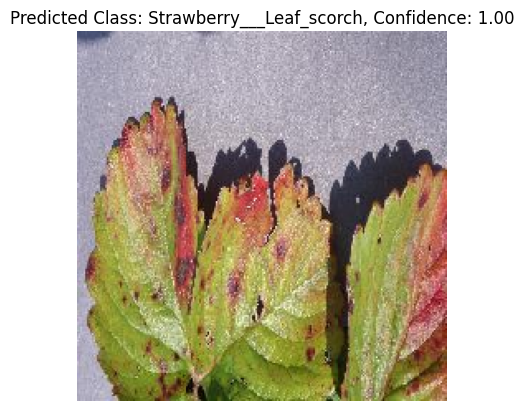

Predicted class: Strawberry___Leaf_scorch
Confidence: 1.00


In [ ]:

image_path = "/content/plantvillage dataset/color/Strawberry___Leaf_scorch/8d8c7caf-b30d-4842-93ae-e0472e41a3e2___RS_L.Scorch 0161.JPG" # Replace with the actual image path in your Kaggle directory
#predicted_class, confidence = test_model_with_image(best_model, image_path)
predicted_class_name, confidence = test_model_with_image(best_model, image_path)

# Display the image and the prediction result
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_name}, Confidence: {confidence:.2f}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class_name}")
print(f"Confidence: {confidence:.2f}")